In [ ]:
image_directory='/content/drive/MyDrive/MedMNIST/breast_mnist/breast_mnist'

In [ ]:

import os
import cv2
from PIL import Image
import numpy as np


In [ ]:
SIZE=150

In [ ]:

# Initialize empty lists to store images and labels
train_dataset = []
train_label = []
test_dataset = []
test_label = []
val_dataset = []
val_label = []

# List of label folders
label_folders = ['[0]', '[1]']

# Load train dataset and label
for label_folder in label_folders:
    image_directory_label = os.path.join(image_directory, 'train', label_folder)
    image_names = os.listdir(image_directory_label)
    for image_name in image_names:
        if image_name.split('.')[1] == 'png':
            image = cv2.imread(os.path.join(image_directory_label, image_name))
            image = Image.fromarray(image, 'RGB')
            image = image.resize((SIZE, SIZE))
            train_dataset.append(np.array(image))
            train_label.append(int(label_folder[1]))

# Load test dataset and label
for label_folder in label_folders:
    image_directory_label = os.path.join(image_directory, 'test', label_folder)
    image_names = os.listdir(image_directory_label)
    for image_name in image_names:
        if image_name.split('.')[1] == 'png':
            image = cv2.imread(os.path.join(image_directory_label, image_name))
            image = Image.fromarray(image, 'RGB')
            image = image.resize((SIZE, SIZE))
            test_dataset.append(np.array(image))
            test_label.append(int(label_folder[1]))

# Load validation dataset and label
for label_folder in label_folders:
    image_directory_label = os.path.join(image_directory, 'val', label_folder)
    image_names = os.listdir(image_directory_label)
    for image_name in image_names:
        if image_name.split('.')[1] == 'png':
            image = cv2.imread(os.path.join(image_directory_label, image_name))
            image = Image.fromarray(image, 'RGB')
            image = image.resize((SIZE, SIZE))
            val_dataset.append(np.array(image))
            val_label.append(int(label_folder[1]))

# Convert the lists to numpy arrays
train_dataset = np.array(train_dataset)
train_label = np.array(train_label)
test_dataset = np.array(test_dataset)
test_label = np.array(test_label)
val_dataset = np.array(val_dataset)
val_label = np.array(val_label)

# Concatenate the datasets and labels
dataset = np.concatenate((train_dataset, test_dataset, val_dataset), axis=0)
label = np.concatenate((train_label, test_label, val_label), axis=0)


In [ ]:
print(dataset.shape,label.shape)

(780, 150, 150, 3) (780,)


In [ ]:
import numpy as np
import cv2

def random_flip(image, axis=1):
    if np.random.random() < 0.5:
        return np.flip(image, axis=axis)
    return image

def random_rotation(image, max_angle=15):
    angle = np.random.uniform(-max_angle, max_angle)
    rows, cols = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    return cv2.warpAffine(image, rotation_matrix, (cols, rows))

def add_gaussian_noise(image, mean=0, std=5):
    noise = np.random.normal(mean, std, image.shape)
    return np.clip(image + noise, 0, 255).astype(np.uint8)

def augment_dataset(images, labels, num_augmentations=4, imbalance_ratio=0.5):
    augmented_images = []
    augmented_labels = []

    # Find the minority class label
    minority_class = np.unique(labels)[np.argmin(np.bincount(labels))]

    # Initialize counters to track the number of augmented samples for each class
    augment_counts = {label: 0 for label in np.unique(labels)}

    for i in range(len(images)):
        num_additional_samples = int(num_augmentations * imbalance_ratio)

        # Augment the minority class samples more
        if labels[i] == minority_class:
            num_additional_samples = min(num_augmentations, num_additional_samples)

        for _ in range(num_additional_samples):
            augmented_image = random_flip(images[i], axis=1)
            augmented_image = random_rotation(augmented_image, max_angle=15)
            augmented_image = add_gaussian_noise(augmented_image, mean=0, std=5)
            augmented_images.append(augmented_image)
            augmented_labels.append(labels[i])

            # Increment the counter for the class of the current image
            augment_counts[labels[i]] += 1

        # If the minority class has already reached the desired number of augmentations, skip further augmentations
        if augment_counts[minority_class] >= num_augmentations:
            continue

    # Combine the original images and augmented images
    extended_images = np.vstack([images, augmented_images])
    extended_labels = np.hstack([labels, augmented_labels])

    return extended_images, extended_labels



In [ ]:
imbalance_ratio = 0.5

# Perform data augmentation to extend the dataset and address class imbalance
extended_images, extended_labels = augment_dataset(dataset, label, num_augmentations=4, imbalance_ratio=imbalance_ratio)


In [ ]:
np.save('extended_images.npy', extended_images)
np.save('extended_labels.npy', extended_labels)

In [ ]:
extended_images.shape

(2340, 150, 150, 3)

In [ ]:
extended_labels.shape

(2340,)

In [ ]:
from sklearn.model_selection import train_test_split
train_images, test_images, train_labels, test_labels = train_test_split(
    extended_images, extended_labels, test_size=0.2, random_state=42)




In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout


In [ ]:

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

In [ ]:
import tensorflow as tf
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 activation_5 (Activation)   (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_6 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                  

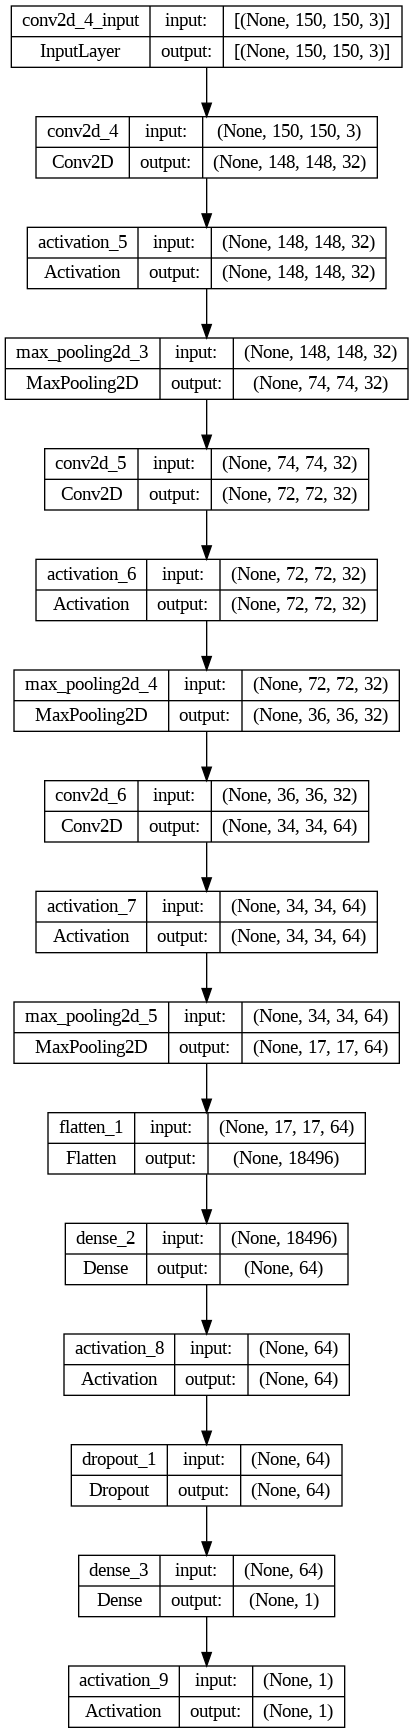

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='/content/drive/MyDrive/models/model1_diagram.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(train_images,
                         train_labels,
                         verbose = 1,
                         epochs = 10,
                         validation_data=(test_images,test_labels),
                     )

Epoch 1/10
59/59 [==============================] - 68s 1s/step - loss: 14.3205 - accuracy: 0.6832 - val_loss: 0.6890 - val_accuracy: 0.7415
Epoch 2/10
59/59 [==============================] - 68s 1s/step - loss: 0.6193 - accuracy: 0.7281 - val_loss: 0.5255 - val_accuracy: 0.7521
Epoch 3/10
59/59 [==============================] - 68s 1s/step - loss: 0.5688 - accuracy: 0.7447 - val_loss: 0.5133 - val_accuracy: 0.8013
Epoch 4/10
59/59 [==============================] - 64s 1s/step - loss: 0.5283 - accuracy: 0.7548 - val_loss: 0.4676 - val_accuracy: 0.8034
Epoch 5/10
59/59 [==============================] - 69s 1s/step - loss: 0.5036 - accuracy: 0.7714 - val_loss: 0.4501 - val_accuracy: 0.7885
Epoch 6/10
59/59 [==============================] - 65s 1s/step - loss: 0.5150 - accuracy: 0.7612 - val_loss: 0.4736 - val_accuracy: 0.7863
Epoch 7/10
59/59 [==============================] - 81s 1s/step - loss: 0.4885 - accuracy: 0.7783 - val_loss: 0.5028 - val_accuracy: 0.8013
Epoch 8/10
59/59 [=

In [ ]:
model.save('/content/drive/MyDrive/model1-1.h5')


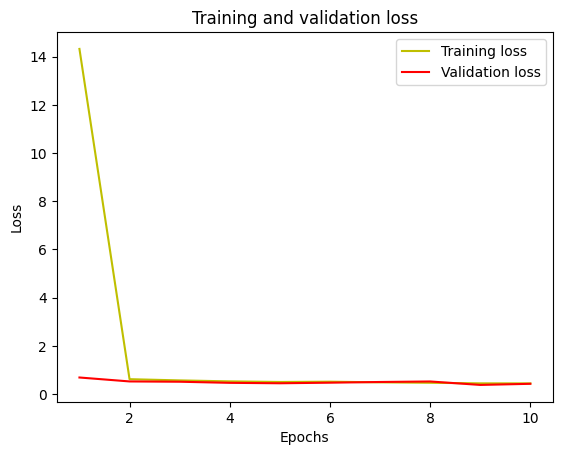

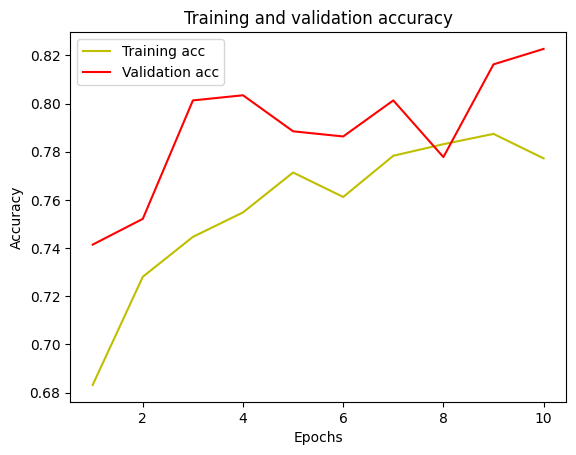

In [ ]:
#plot the training and validation accuracy and loss at each epoch
from matplotlib import pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
history1 = model.fit(train_images,
                         train_labels,
                         verbose = 1,
                         epochs = 20,
                         validation_data=(test_images,test_labels),
                     )

Epoch 1/20
59/59 [==============================] - 110s 2s/step - loss: 0.3994 - accuracy: 0.7922 - val_loss: 0.4010 - val_accuracy: 0.8248
Epoch 2/20
59/59 [==============================] - 126s 2s/step - loss: 0.4147 - accuracy: 0.7885 - val_loss: 0.4051 - val_accuracy: 0.8226
Epoch 3/20
59/59 [==============================] - 81s 1s/step - loss: 0.4270 - accuracy: 0.7933 - val_loss: 0.4238 - val_accuracy: 0.8077
Epoch 4/20
59/59 [==============================] - 70s 1s/step - loss: 0.3821 - accuracy: 0.8013 - val_loss: 0.3630 - val_accuracy: 0.8184
Epoch 5/20
59/59 [==============================] - 66s 1s/step - loss: 0.3471 - accuracy: 0.8040 - val_loss: 0.3542 - val_accuracy: 0.8291
Epoch 6/20
59/59 [==============================] - 67s 1s/step - loss: 0.3300 - accuracy: 0.8072 - val_loss: 0.4035 - val_accuracy: 0.8141
Epoch 7/20
59/59 [==============================] - 64s 1s/step - loss: 0.3096 - accuracy: 0.8333 - val_loss: 0.3497 - val_accuracy: 0.8291
Epoch 8/20
59/59 [

In [ ]:
model.save('/content/drive/MyDrive/models/breastmodel1.h5')


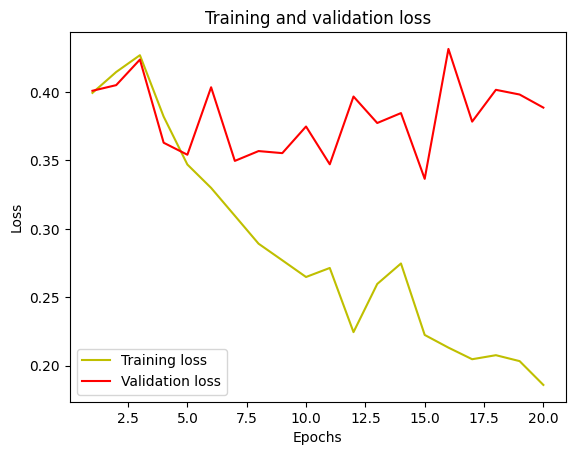

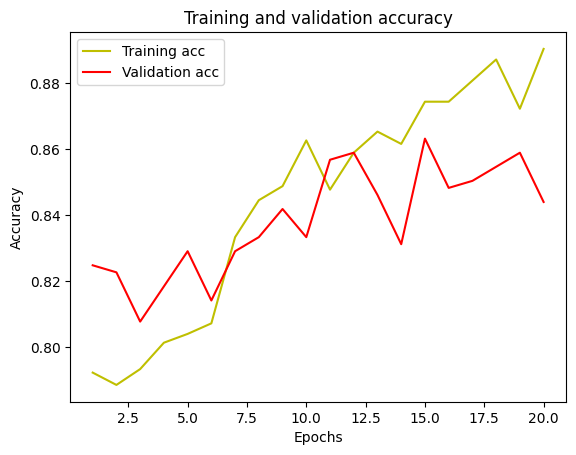

In [ ]:
#plot the training and validation accuracy and loss at each epoch
from matplotlib import pyplot as plt
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 264ms/step
The prediction for this image is:  [[1.]]
The actual label for this image is:  1


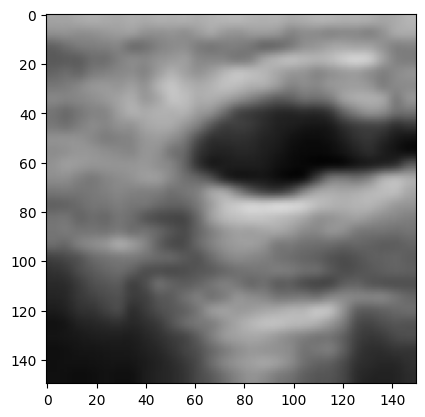

In [ ]:
n=24  #Select the index of image to be loaded for testing
img = test_images[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", model.predict(input_img))
print("The actual label for this image is: ", test_labels[n])


In [ ]:
from keras.models import load_model
# load model
model = load_model('/content/drive/MyDrive/models/breastmodel1.h5')

_, acc = model.evaluate(test_images, test_labels)
print("Accuracy = ", (acc * 100.0), "%")


15/15 [==============================] - 5s 326ms/step - loss: 0.3887 - accuracy: 0.8440
Accuracy =  84.40170884132385 %


In [ ]:
#Confusion matrix
#We compare labels and plot them based on correct or wrong predictions.
#Since sigmoid outputs probabilities we need to apply threshold to convert to label.

mythreshold=0.908
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = (model.predict(test_images)>= mythreshold).astype(int)
cm=confusion_matrix(test_labels, y_pred)
print(cm)

print('Classification Report')

target_names=['malignant','normal benign']

print(classification_report(test_labels,y_pred,target_names=target_names))



15/15 [==============================] - 6s 334ms/step
[[104  17]
 [101 246]]
Classification Report
               precision    recall  f1-score   support

    malignant       0.51      0.86      0.64       121
normal benign       0.94      0.71      0.81       347

     accuracy                           0.75       468
    macro avg       0.72      0.78      0.72       468
 weighted avg       0.82      0.75      0.76       468



Text(109.44999999999997, 0.5, 'Predicted Values')

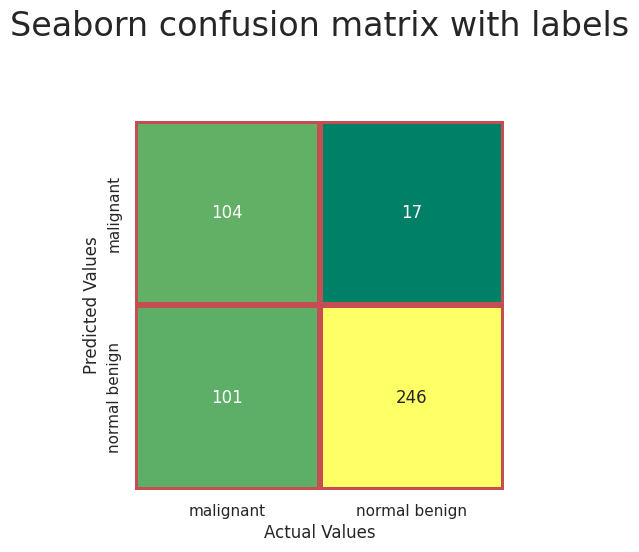

In [ ]:
import seaborn as sns
sns.set(font_scale=1.0)
ax=sns.heatmap(cm,annot=True, cmap='summer',cbar=False,linecolor='r',linewidth=3,square=True,xticklabels=target_names,yticklabels=target_names,fmt='d')

sns.set(font_scale=2.0)
ax.set_title('Seaborn confusion matrix with labels\n\n')
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')

15/15 [==============================] - 7s 449ms/step


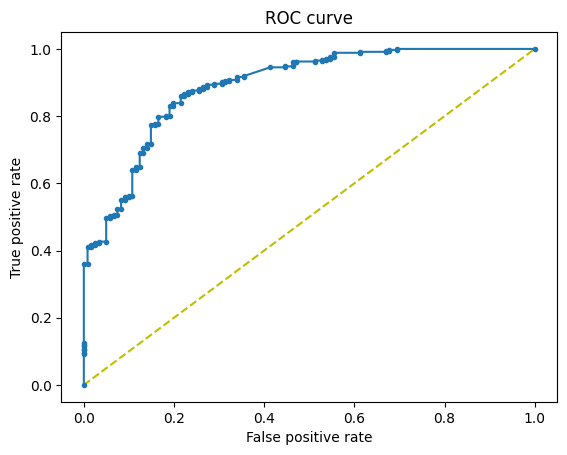

In [ ]:
#ROC
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
y_preds = model.predict(test_images).ravel()

fpr, tpr, thresholds = roc_curve(test_labels, y_preds)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [ ]:
import pandas as pd
i = np.arange(len(tpr))
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds'])


Ideal threshold is:  49    0.814824
Name: thresholds, dtype: float32


In [ ]:
from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)

Area under curve, AUC =  0.8912401457594017
